# Up/down wavefield separation
**Author: M.Ravasi**

This notebook applies up/down wavefield separation to the multi-component data `input_full_volvesynth`. The up and down separated wavefields are saved in the directory `Data/Processing` for further use.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.signal import filtfilt
from pylops.basicoperators import *
from pylops.signalprocessing import *

from segyshot import SegyShot
from calibrate import calibrate

## Data loading

In [2]:
fsynth = np.load('../Data/Modelling/input_full_volvesynth.npz') 

psynth = fsynth['p'].transpose(0, 2, 1)
vzsynth = fsynth['vz'].transpose(0, 2, 1)
tsynth = fsynth['t']
rsynth = fsynth['r']
ssynth = fsynth['s']
t = fsynth['t']
wav = fsynth['wav']

ns, nr, nt = psynth.shape
dr = np.round(rsynth[0,1]-rsynth[0,0])
dt = t[1]-t[0]

## Wavefield separation

Create separation operators

In [3]:
# separation
nfft = nt
vel_dir = 1480.0 # velocity of water
vel_sep = 1900.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level
critical = 0.9
ntaper = 9
cutoff = 1e7

# calibration params
twin = [0.01, 0.07]
nfilt = 15

# fft
FFTop = FFT2D(dims=[nr, nt], nffts=[nfft, nfft], sampling=[dr, dt])

# obliquity factor
[Kx, F] = np.meshgrid(FFTop.f1, FFTop.f2, indexing='ij')
k=F/vel_sep
Kz=np.sqrt((k**2-Kx**2).astype(np.complex))
Kz[np.isnan(Kz)] = 0

OBL=rho_sep*(np.abs(F)/Kz)
OBL[Kz==0]=0
OBL[OBL>cutoff]=0

OBL1 = Kz /(rho_sep*np.abs(F))
OBL1[F==0] = 0
OBL1[OBL1<1./cutoff]=0

# cut off and taper
mask = np.abs(Kx)<critical*np.abs(F)/vel_sep
mask = filtfilt(np.ones(ntaper)/float(ntaper), 1, mask, axis=0)
mask = filtfilt(np.ones(ntaper)/float(ntaper), 1, mask, axis=1)

OBL = OBL*mask
OBL1 = OBL1*mask

# analytical separation
Maskop = Diagonal(mask.ravel(), dtype='complex128')
OBLop = Diagonal(OBL.ravel(), dtype='complex128')

Sop = 0.5*(BlockDiag([FFTop.H, FFTop.H])*\
    Block([[Maskop, OBLop],
           [Maskop, -OBLop]])*\
           BlockDiag([FFTop, FFTop]))

In [4]:
pup = np.zeros((ns, nt, nr))
pdown = np.zeros((ns, nt, nr))

for isrc in range(0, ns):
    if isrc % 10 == 0:
        print(f'Working with source {isrc}/{ns}')
    vzcalib = calibrate(psynth[isrc], vzsynth[isrc], ssynth, rsynth, isrc, dt, nt, vel_dir, vel_sep, 
                        rho_sep, twin=twin, nfilt=nfilt, plotflag=False)

    d = np.concatenate((psynth[isrc].ravel(), vzcalib.ravel()))
    dud = np.real(Sop * d)

    d = d.reshape(2*nr, nt)
    dud = dud.reshape(2*nr, nt)
    pdown[isrc], pup[isrc] = dud[:nr].T, dud[nr:].T

Working with source 0/110
Working with source 10/110
Working with source 20/110
Working with source 30/110
Working with source 40/110
Working with source 50/110
Working with source 60/110
Working with source 70/110
Working with source 80/110
Working with source 90/110
Working with source 100/110


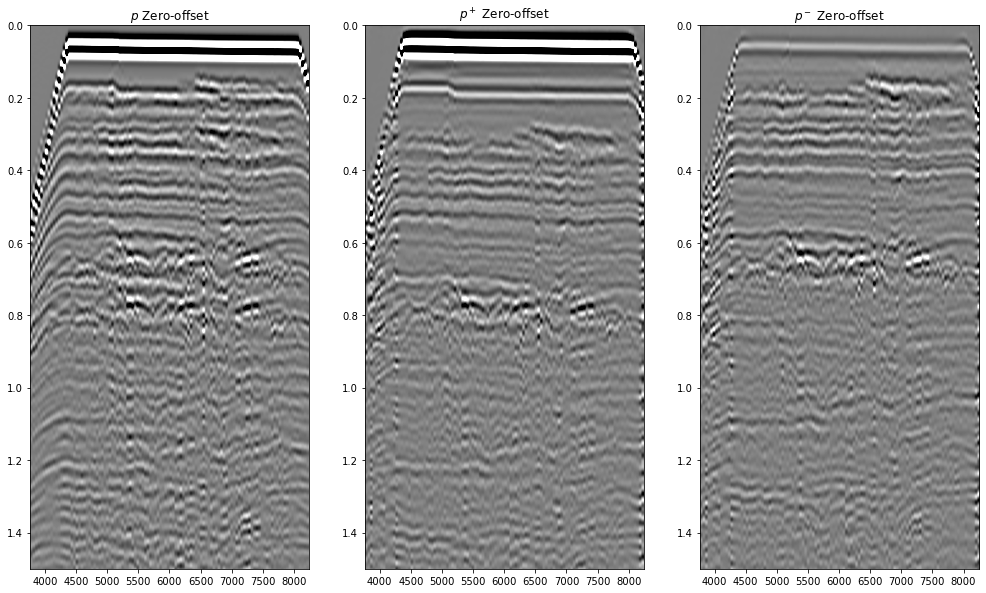

In [5]:
p_zo = np.zeros((ns, nt))
pup_zo = np.zeros((ns, nt))
pdown_zo = np.zeros((ns, nt))

for isrc in range(ns):
    irec_zo = np.argmin(np.abs(ssynth[0, isrc]-rsynth[0]))
    p_zo[isrc] = psynth[isrc, irec_zo]
    pup_zo[isrc], pdown_zo[isrc] = pup[isrc, :, irec_zo], pdown[isrc, :, irec_zo]

clip = 0.1
fig, axs = plt.subplots(1, 3, figsize=(17,10))
axs[0].imshow(p_zo.T, cmap='gray', vmin=-clip*np.abs(p_zo).max(), vmax=clip*np.abs(p_zo).max(),
              extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
axs[0].set_title(r'$p$ Zero-offset')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(pdown_zo.T, cmap='gray', vmin=-clip*np.abs(p_zo).max(), vmax=clip*np.abs(p_zo).max(),
              extent = (rsynth[0,0], rsynth[0,-1], t[-1], t[0]))
axs[1].set_title(r'$p^+$ Zero-offset')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(pup_zo.T, cmap='gray', vmin=-clip*np.abs(p_zo).max(), vmax=clip*np.abs(p_zo).max(),
              extent = (rsynth[0,0], rsynth[0,-1], t[-1], t[0]))
axs[2].set_title(r'$p^-$ Zero-offset')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0);

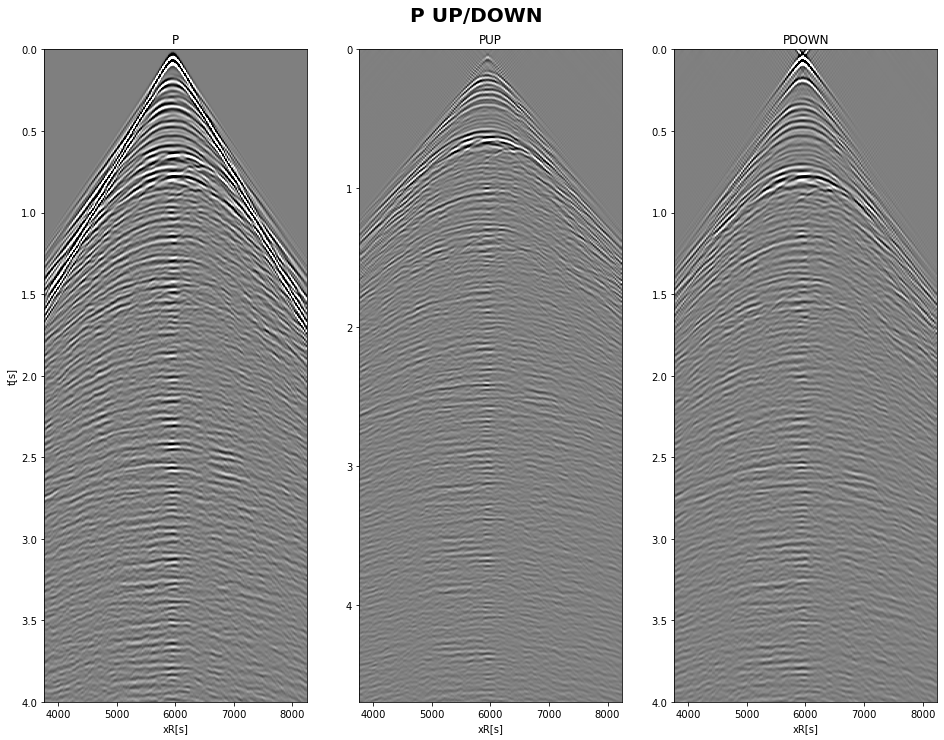

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(16, 12))
fig.suptitle('P UP/DOWN', y=0.93, fontsize=20, fontweight='bold')
axs[0].imshow(psynth[59].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[0].set_ylabel('t[s]')
axs[0].set_xlabel('xR[s]')
axs[0].set_ylabel('t[s]')
axs[0].set_title('P')
axs[0].axis('tight')
axs[0].set_ylim(4, 0)
axs[1].imshow(pup[59], cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[1].set_xlabel('xR[s]')
axs[1].set_title('PUP')
axs[1].axis('tight')
axs[2].imshow(pdown[59], cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[2].set_xlabel('xR[s]')
axs[2].set_title('PDOWN')
axs[2].axis('tight')
axs[2].set_ylim(4, 0)
plt.savefig('../Figures/Volve_synthdata_updown.png');

## Save results